### Import the necessary packages

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import prince
from sklearn.cluster import KMeans
from pyod.models.knn import KNN

### Read in the unmodified original data to explore trying to predict the weight column

In [21]:
unmod_df = pd.read_csv('diabetic_data.csv')

In [32]:
#Replace "?" values with nan since these are missing values
unmod_df.replace('?',np.nan,inplace=True)
#Get rows where weight, race, gender, and age are not null
weight_df = unmod_df[unmod_df['weight'].notnull()&unmod_df['race'].notnull()&unmod_df['age'].notnull()&unmod_df['gender'].notnull()]
#Drop all rows except weight, race, age, and gender
weight_df = weight_df[['weight','race','age','gender']]
#Get dummy variables for the predictor column
weight_df = pd.get_dummies(weight_df,columns=['race','gender','age'])
#Relevel weight so that it's binary whether someone is over 100 pounds or not
weight_dict = {'[0-25)':0,'[25-50)':0, '[50-75)':0,'[75-100)':0,'[100-125)':1,'[125-150)':1,'[150-175)':1,'[175-200)':1,'>200':1,np.nan:np.nan}
weight_df['weight'] = weight_df['weight'].map(weight_dict)
#Get all rows except for the weight column to be the predictors
X = weight_df.drop('weight',axis=1)
#Get the weight column as the target column
y = weight_df['weight']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#Fit a random forest model
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
#Get accuracy on the test set
print('Test Set Accuracy: {}'.format(rf.score(X_test,y_test)))

Test Set Accuracy: 0.7549019607843137


### Read in the already slightly preprocessed data

In [17]:
orig_df = pd.read_csv('ogpreprocessed.csv')

In [18]:
#Visualize the fact that patients can have multiple visits
orig_df[orig_df['patient_nbr']==1152]

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,change,diabetesMed,readmitted,Biguanide,Meglitinide,Sulfonylurea,Thiazolidinedione,Alpha-glucosidase inhibitor,Loop Diuretic,Dipeptidyl peptidase-4 inhibitor
5635,30180318,1152,AfricanAmerican,Female,[50-60),1,1,3,6,Hematology/Oncology,...,Ch,Yes,>30,0,0,0,0,0,0,0
13518,55533660,1152,AfricanAmerican,Female,[60-70),1,1,3,10,Hematology/Oncology,...,No,Yes,>30,0,0,0,0,0,0,0
23612,83281464,1152,AfricanAmerican,Female,[60-70),1,1,3,12,Hematology/Oncology,...,Ch,Yes,NO,0,0,0,0,0,0,0


## Collapse Rows with Repeated Patient Numbers Into 1 Row

In [19]:
#Collapse the quantitative variables by just taking the mean of the series after grouping by patient number
df = orig_df.groupby('patient_nbr')[['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']].mean()

In [35]:
#Collapse the categorical variables by taking the top value count (i.e. the mode) of the series after grouping by patient number
df[['race','gender','age','admission_type_id','discharge_disposition_id','admission_source_id','medical_specialty','diag_1','diag_2','diag_3','insulin','change','diabetesMed','readmitted','Biguanide','Meglitinide','Sulfonylurea','Thiazolidinedione','Alpha-glucosidase inhibitor','Loop Diuretic','Dipeptidyl peptidase-4 inhibitor']] = orig_df.groupby('patient_nbr')[['race','gender','age','admission_type_id','discharge_disposition_id','admission_source_id','medical_specialty','diag_1','diag_2','diag_3','insulin','change','diabetesMed','readmitted','Biguanide','Meglitinide','Sulfonylurea','Thiazolidinedione','Alpha-glucosidase inhibitor','Loop Diuretic','Dipeptidyl peptidase-4 inhibitor']].agg(lambda x: x.value_counts().index[0])

## Fix various issues with the variables

In [36]:
#Replace "?" values with nan since these are missing values
df.replace('?',np.nan,inplace=True)
#Drop rows where we don't have race since it's a relatively small amount
df.dropna(inplace=True,subset = ['race'])
#Remove all rows where gender is unknown since there's so few
df = df[df['gender']!='Unknown/Invalid']
#Relevel the race variable to condense the uncommon levels into the "Other" level
race_dict = {'Caucasian':'Caucasian','AfricanAmerican':'AfricanAmerican','Hispanic':'Other','Other':'Other','Asian':'Other'}
df['race'] = df['race'].map(race_dict)
#Relevel the age variable to be above 60 and below 60
age_dict = {'[0-10)':0,'[10-20)':0,'[20-30)':0,'[30-40)':0,'[40-50)':0,'[50-60)':0,'[60-70)':1,'[70-80)':1,'[80-90)':1,'[90-100)':1}
# df['above_60'] = df['age'].map(age_dict)
#Get dummy variables for gender and race
df = pd.get_dummies(df,columns=['gender','race'],drop_first=True)
#Relevel the insulin column so that it's binary (0 if they are not on insulin and 1 if they are)
df['insulin'] = df['insulin'].map({'No':0,'Steady':1,'Up':1,'Down':1})
#Relevel the change column so that it's binary (0 if their medicine or dosage doesn't change and 1 if it does)
df['change'] = df['change'].map({'No':0,'Ch':1})
#Drop the medical specialty column since there's too many NA's
df.drop(['medical_specialty'],axis=1,inplace=True)
#Drop the Loop Diuretic and Dipeptidyl peptidase-4 inhibitor columns since they are all 0's
df.drop(['Loop Diuretic','Dipeptidyl peptidase-4 inhibitor'],axis=1,inplace=True)
#Drop the diabetesMed column since it's inconsistent with the drug columns that we have and is redundant information
df.drop(['diabetesMed'],axis=1,inplace=True)
#Drop the age variable since we releveled it earlier and created a new above_60 column
df.drop(['age'],axis=1,inplace=True)
#Drop rows where discharge_disposition_id is 2 since these are patients who died
df = df[df['discharge_disposition_id']!=2]
#Get dummies for the various ID variables
df = pd.get_dummies(df,columns=['admission_type_id','discharge_disposition_id','admission_source_id'],drop_first=True)

In [37]:
#Turn all non-numeric values of diag_1, diag_2, and diag_3 to be NA
df['diag_1'] = pd.to_numeric(df['diag_1'], errors='coerce')
df['diag_2'] = pd.to_numeric(df['diag_2'], errors='coerce')
df['diag_3'] = pd.to_numeric(df['diag_3'], errors='coerce')
#Use ICD-9 codes to group the diag columns into distinct medical areas
def relabel_diag(row):
    if (row > 249) & (row < 251):
        row = 'Diabetes'
    elif (row > 389) & (row < 460):
        row = 'Circulatory'
    elif (row > 459) & (row < 520):
        row = 'Respiratory'
    elif (row > 519) & (row < 580):
        row = 'Digestive'
    elif (row > 579) & (row < 630):
        row = 'Genitourinary'
    elif (row > 799) & (row < 1000):
        row = 'Injury'
    elif (row > 709) & (row < 740):
        row = 'Musculoskeletal'
    else:
        row = 'Other'
    return row
#Change the diag_1, diag_2, and diag_3 columns to be the new labels
df['diag_1'] = df['diag_1'].map(relabel_diag)
df['diag_2'] = df['diag_2'].map(relabel_diag)
df['diag_3'] = df['diag_3'].map(relabel_diag)
#Get dummy variables for the new diag_1, diag_2, and diag_3 columns
df = pd.get_dummies(df,columns=['diag_1','diag_2','diag_3'],drop_first=True)

In [38]:
#Reset the index so that it's the row number, not the patient number
df.reset_index(inplace=True)
#Drop the patient_nbr variable since we don't need it after we've reset the index
df.drop(['patient_nbr'],axis=1,inplace=True)

## Briefly visualize the differences in the target variable between the binary and multiclass problems

In [39]:
#Make a copy of the data frame that keeps the original class labels so that we can try a multiclass problem
df_multiclass = df.copy()
#Relevel the readmitted column so that it's binary (0 if they are not readmitted within 30 days and 1 if they are)
df['readmitted'] = df['readmitted'].map({'NO':0,'>30':1,'<30':1})

### Target variable - binary problem

Text(0.5, 1.0, 'Readmitted Variable Distribution')

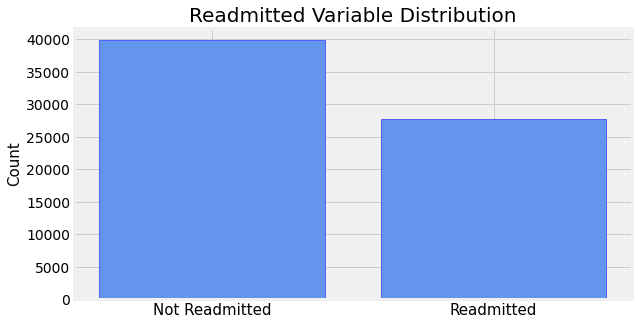

In [40]:
#Get the counts of each of the three classes
binary_class_counts = df['readmitted'].value_counts()
#Make a bar plot of the class counts
plt.figure(figsize=(10,5))
#Use the FiverThirtyEight style for a cleaner looking plot
plt.style.use('fivethirtyeight')
plt.bar(binary_class_counts.index,binary_class_counts.values, color = 'cornflowerblue', edgecolor = 'blue')
plt.xticks(binary_class_counts.index, ('Not Readmitted', 'Readmitted'),fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Readmitted Variable Distribution',fontsize=20)

### Target variable - multiclass problem

Text(0.5, 1.0, 'Readmitted Variable Distribution')

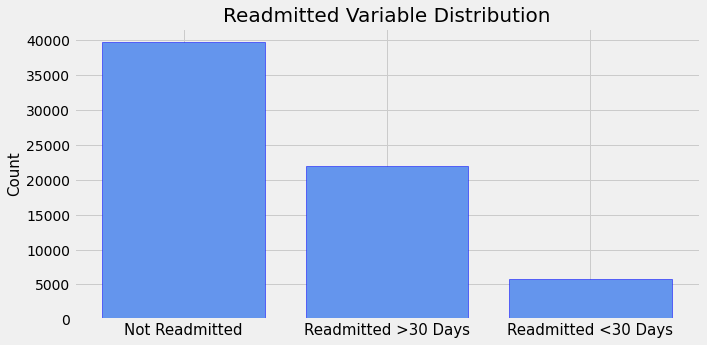

In [41]:
#Get the counts of each of the three classes
multiclass_class_counts = df_multiclass['readmitted'].value_counts()
#Make a bar plot of the class counts
plt.figure(figsize=(10,5))
#Use the FiverThirtyEight style for a cleaner looking plot
plt.style.use('fivethirtyeight')
plt.bar(multiclass_class_counts.index,multiclass_class_counts.values, color = 'cornflowerblue', edgecolor = 'blue')
plt.xticks(multiclass_class_counts.index, ('Not Readmitted', 'Readmitted >30 Days', 'Readmitted <30 Days'),fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Readmitted Variable Distribution',fontsize=20)

## Begin feature reduction

### Examine correlations between the variables

Text(0.5, 1.0, 'Correlation Heatmap')

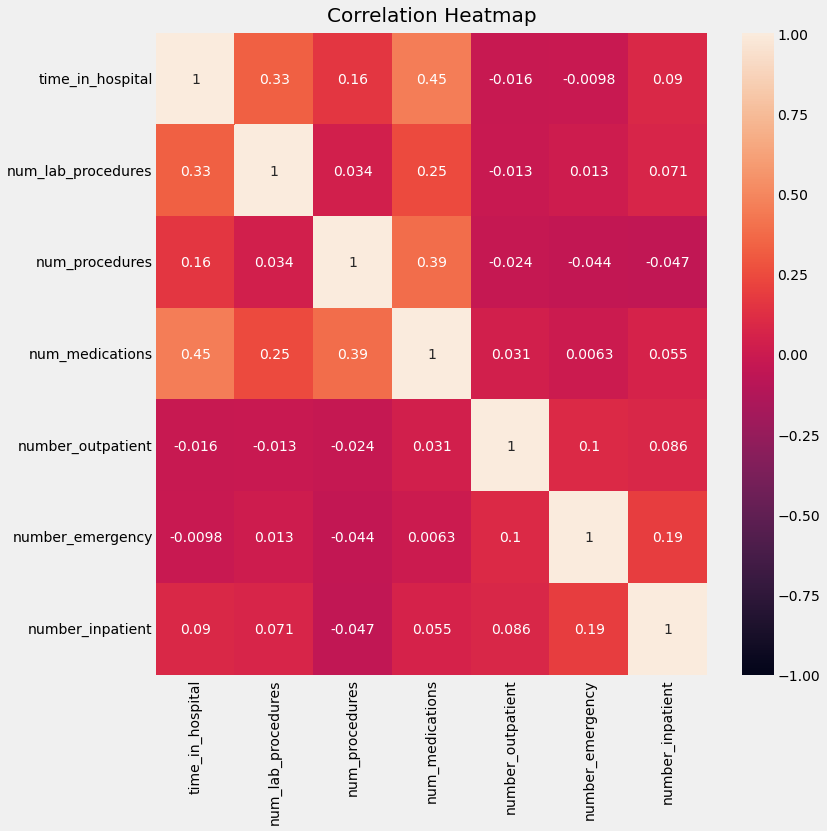

In [42]:
#Get only quantitative columns to compute correlations of
df_quant = df[['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient']]
#Compute correlations between these quantitative variables and output a heatmap
corr = df_quant.corr()
plt.figure(figsize=(11, 11))
heatmap = sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)

### Splitting into train and test sets

In [43]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['readmitted'],axis=1),df['readmitted'],test_size=0.25,random_state=1)
#Getting the quantitative variables
X_train_quant = X_train.loc[:, df_quant.columns]

In [44]:
#Recombine the x and y parts to get the full train and test sets
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
#Write the train and test sets to .csv files
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

### Split the multiclass data into train and test sets

In [48]:
#Get the training and test sets for the multiclass problem and also write them to .csv files
X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(df_multiclass.drop(['readmitted'],axis=1),df_multiclass['readmitted'],test_size=0.25,random_state=1)
train_multiclass = pd.concat([X_train_multiclass, y_train_multiclass], axis=1)
test_multiclass = pd.concat([X_test_multiclass, y_test_multiclass], axis=1)
train_multiclass.to_csv('train_multiclass.csv', index=False)
test_multiclass.to_csv('test_multiclass.csv', index=False)

### Seeing if we should be removing outliers

In [49]:
clf = KNN()
#Fit the model using training data
clf.fit(X_train_quant)
#Get the outlier scores for the training data
outlier_pred = clf.predict(X_train_quant)
#Add the outlier column to the quantitative training data
X_train_quant['outlier'] = outlier_pred
#See which rows are outliers to make sure that they aren't entry errors
X_train_quant[X_train_quant['outlier']==1]

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,outlier
35621,11.0,61.0,5.0,21.0,1.0,0.0,2.0,1
54521,2.0,1.0,0.0,8.0,17.0,0.0,0.0,1
63632,8.0,34.0,1.0,36.0,0.0,0.0,1.0,1
7995,13.0,62.0,6.0,49.0,0.0,0.0,0.0,1
62355,1.0,49.0,1.0,10.0,0.0,0.0,7.0,1
...,...,...,...,...,...,...,...,...
54347,13.0,65.0,0.0,9.0,0.0,1.0,0.0,1
12313,3.5,59.5,0.5,18.0,0.0,6.5,5.5,1
35437,2.0,26.5,1.0,20.0,4.5,0.0,2.5,1
56260,1.5,47.0,2.5,19.0,4.5,0.0,1.0,1


### Scale the data 

In [50]:
#Drop the outlier column after we displayed it above
X_train_quant.drop('outlier',axis=1,inplace=True)
#Standardizing the quantitative variables
X_train_quant_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train_quant),index=X_train_quant.index)
#Rename the columns to be the same as the original data
X_train_quant_scaled.columns = X_train_quant.columns
#scale the test data according to the training data
X_test_quant_scaled = pd.DataFrame(StandardScaler().fit(X_train_quant).transform(X_test.loc[:, df_quant.columns]),index=X_test.index)
#Rename the columns to be the same as the original data
X_test_quant_scaled.columns = X_train_quant.columns

### Trying out PCA - Quantitative Variables

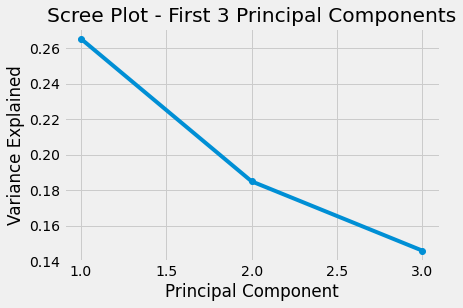

Variance Explained by First 3 Principal Components:  0.5961133286587084


In [51]:
#Establishing the number of principal components to create and actually creating them
pca = PCA(n_components=3)
pr_comp = pca.fit_transform(X_train_quant_scaled)
#Store results in a data frame and add the response variable
df_pca = pd.DataFrame(pr_comp ,columns = ['PC1', 'PC2','PC3'])
df_pca['readmitted'] = y_train.values
#Make a scree plot to see how much variance is explained by each principal component
num_pc = [i for i in range(1,pca.n_components_+1)]
plt.plot(num_pc, pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot - First 3 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()
print('Variance Explained by First 3 Principal Components: ',sum(pca.explained_variance_ratio_))

Text(0.5, 1.0, 'Readmitted Distribution by Principal Components')

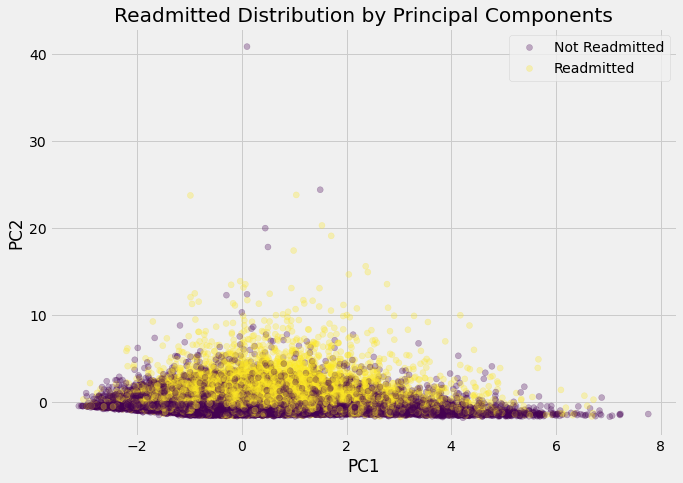

In [52]:
#Plot the scores on the first two principal components and color by the readmitted variable to see how well the principal components
#separate the classes
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_pca['PC1'],df_pca['PC2'],c=df_pca['readmitted'],alpha=0.3)
plt.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Readmitted Distribution by Principal Components')

In [53]:
#Add the three principal components to the training data
X_train['PC1'] = df_pca['PC1'].values
X_train['PC2'] = df_pca['PC2'].values
X_train['PC3'] = df_pca['PC3'].values

Text(0.5, 0.92, 'Readmitted Distribution by Principal Components')

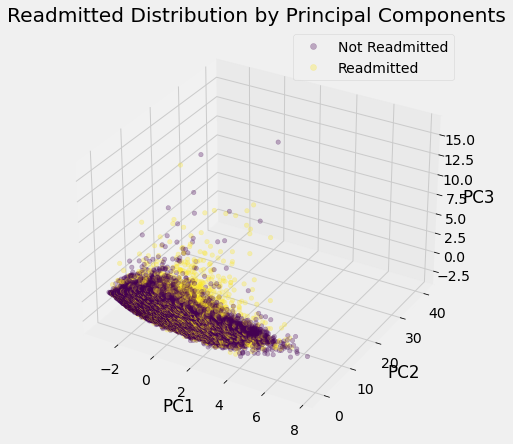

In [54]:
#Plot the scores on the first three principal components and color by the readmitted variable to see how well the principal components
#separate the classes
ax = plt.figure(figsize=(10, 7)).gca(projection='3d')
scatter = ax.scatter(xs=df_pca['PC1'], ys=df_pca['PC2'], zs=df_pca['PC3'], c=df_pca['readmitted'],alpha=0.3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.title('Readmitted Distribution by Principal Components')

Text(0.5, 0, 'Readmitted')

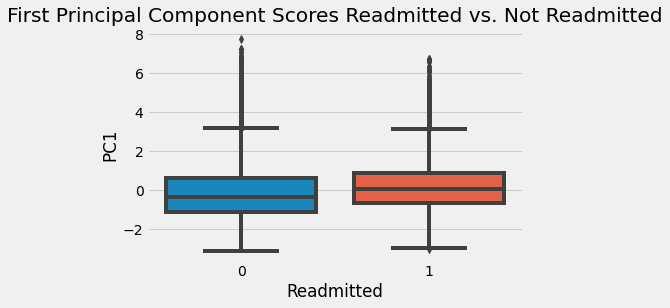

In [55]:
#Make a boxplot comparing the readmitted and not readmitted groups for the first principal component
sns.boxplot(x=df_pca['readmitted'],y=df_pca['PC1'])
plt.title('First Principal Component Scores Readmitted vs. Not Readmitted')
plt.xlabel('Readmitted')

### Trying out t-SNE - Quantitative Variables

In [56]:
#Get two t-SNE components with perplexity of 10
tsne = TSNE(n_components=2, perplexity=10, n_iter=250)
tsne_results = tsne.fit_transform(X_train_quant_scaled)

C:\Users\amcre\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\amcre\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Readmitted Distribution by t-SNE Components')

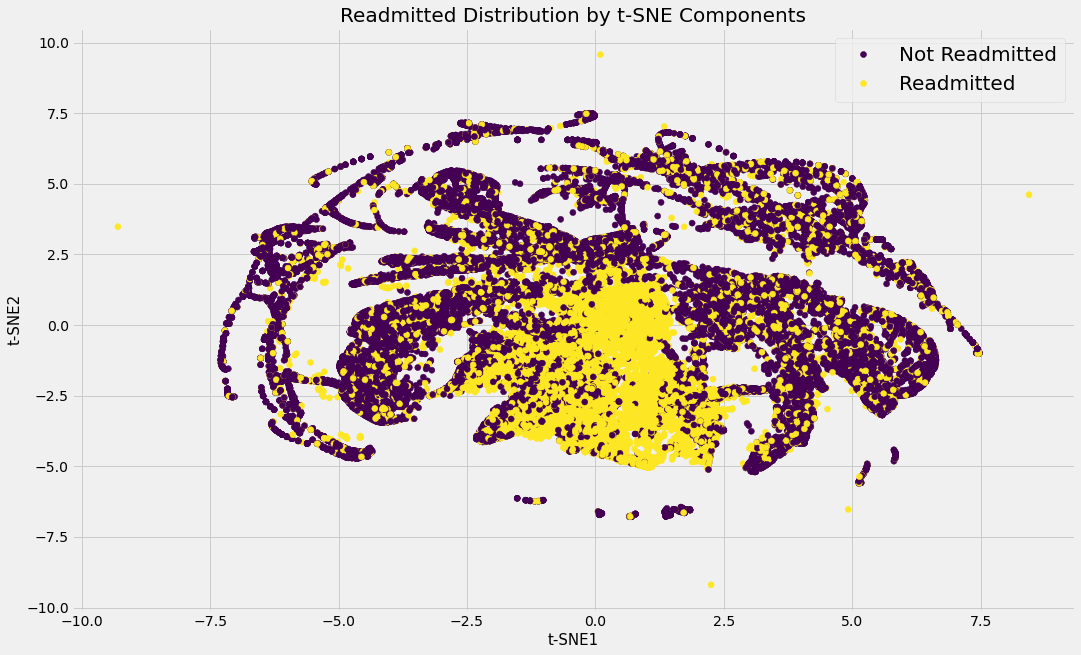

In [57]:
#Set up a data frame with the target variable
df_tsne = pd.DataFrame(y_train)
#Add the two t-SNE components to the data frame
df_tsne['t-SNE1'] = tsne_results[:,0]
df_tsne['t-SNE2'] = tsne_results[:,1]

#Plot the two t-SNE components and color by the readmitted variable to see how well the t-SNE components separate the classes
plt.figure(figsize=(16,10))
scatter = plt.scatter(df_tsne['t-SNE1'],df_tsne['t-SNE2'],c=df_tsne['readmitted'])
plt.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'], fontsize=20)
plt.xlabel('t-SNE1', fontsize=15)
plt.ylabel('t-SNE2', fontsize=15)
plt.title('Readmitted Distribution by t-SNE Components', fontsize=20)

### Trying out LDA

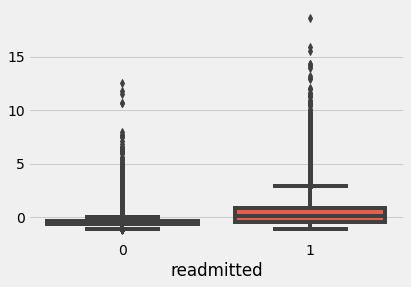

In [58]:
#Set up LDA model
lda = LinearDiscriminantAnalysis()
#Fit the model to the quantitative variables with the readmitted variable being the class to try to separate on
lda.fit(X_train_quant_scaled,y_train)
#Apply the model to the quantitative variables
lda_scores = lda.transform(X_train_quant_scaled)
#Store the results and the target variable together in a data frame
df_lda = pd.DataFrame(lda_scores,columns=['LDA1'],index=X_train.index)
df_lda['readmitted'] = y_train
#Make a boxplot of the transformed data faceted by the readmitted variable
sns.boxplot(x=df_lda['readmitted'],y=lda_scores[:,0],data=df)
#Add the LDA component to the training data
X_train['LDA1'] = df_lda['LDA1'].values
#Add the LDA component to the test data
X_test['LDA1'] = lda.transform(X_test_quant_scaled)

Text(0.5, 1.0, 'LDA1 Distribution by Readmitted Status')

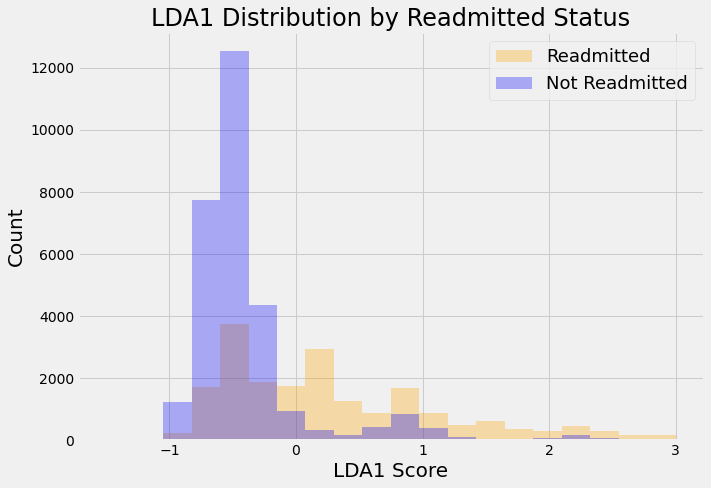

In [59]:
#Make two histograms showing the distribution of LDA1 for the readmitted and not readmitted classes
plt.figure(figsize=(10, 7))
#Split into two data frames, one with readmitted patients and one without
readmitted = df_lda[df_lda['readmitted']==1]
no_readmitted = df_lda[df_lda['readmitted']==0] 
plt.hist(readmitted['LDA1'], bins=20, alpha=0.3, range = [-1.5,3], label='Readmitted',color='orange')
plt.hist(no_readmitted['LDA1'], bins=20, alpha=0.3, range = [-1.5,3], label='Not Readmitted',color='blue')
#Increase the fontsize for the axes and the legend
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=18)
plt.xlabel('LDA1 Score',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.title('LDA1 Distribution by Readmitted Status',fontsize=24)

In [60]:
#Find the correlation between the LDA1 variable and the readmitted variable
df_lda.corr()

,LDA1,readmitted
LDA1,1.000000,0.391063
readmitted,0.391063,1.000000


### Trying clustering

In [61]:
#Do kmeans clustering on df_quant
clusters = KMeans(n_clusters=3, random_state=0).fit(X_train_quant_scaled)
#Add the cluster labels to the data frame
X_train_quant_scaled['cluster'] = clusters.labels_
#Look at the separation of the readmitted variable among the created clusters
print(pd.crosstab(X_train_quant_scaled['cluster'],y_train))

readmitted      0      1
cluster                 
0            1087   3779
1           20560  11442
2            8097   5652


### Trying MCA - Drugs Columns

Text(0.5, 1.0, 'Readmitted Distribution by MCA Components')

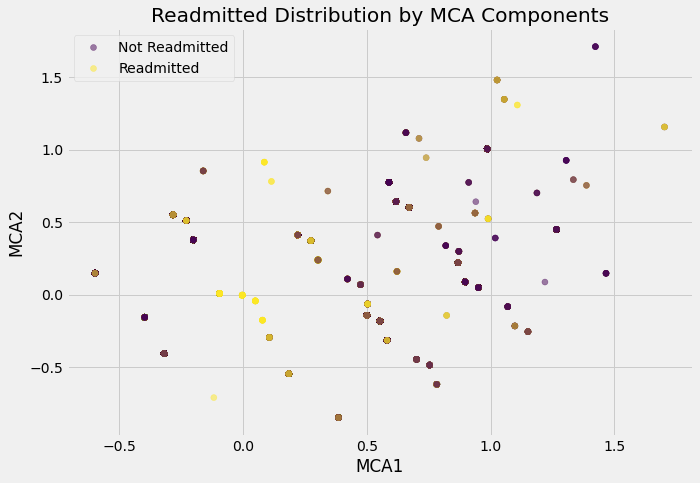

In [62]:
#Get just the columns corresponding to whether a particular drug was prescribed or not
df_drugs = X_train.loc[:,'insulin':'Alpha-glucosidase inhibitor']
#for each drug in df_drugs, change 0 to "No" and 1 to "Yes"
for col in df_drugs.columns:
    df_drugs[col] = df_drugs[col].replace({0:'No',1:'Yes'})
#Do MCA on the drugs columns
mca = prince.MCA(n_components = 3, random_state = 1)
mca_fitted = mca.fit(df_drugs)
mca = mca_fitted.transform(df_drugs)
#Rename the columns
mca.columns = ['MCA1','MCA2','MCA3']
#Add the target variable to the data frame
mca['readmitted'] = y_train
#Plot the first two MCA components colored by the readmitted variable
plt.figure(figsize=(10, 7))
scatter = plt.scatter(mca['MCA1'],mca['MCA2'],c=mca['readmitted'],alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.xlabel('MCA1')
plt.ylabel('MCA2')
plt.title('Readmitted Distribution by MCA Components')

In [63]:
#Add the MCA components to the training data
X_train['MCA1'] = mca['MCA1'].values
X_train['MCA2'] = mca['MCA2'].values
X_train['MCA3'] = mca['MCA3'].values
#Add the MCA components to the test data
df_drugs_test = X_test.loc[:,'insulin':'Alpha-glucosidase inhibitor']
for col in df_drugs_test.columns:
   df_drugs_test[col] = df_drugs_test[col].replace({0:'No',1:'Yes'})
X_test['MCA1'] = mca_fitted.transform(df_drugs_test).values[:,0]
X_test['MCA2'] = mca_fitted.transform(df_drugs_test).values[:,1]
X_test['MCA3'] = mca_fitted.transform(df_drugs_test).values[:,2]


Text(0.5, 0.92, 'Readmitted Distribution by MCA Components')

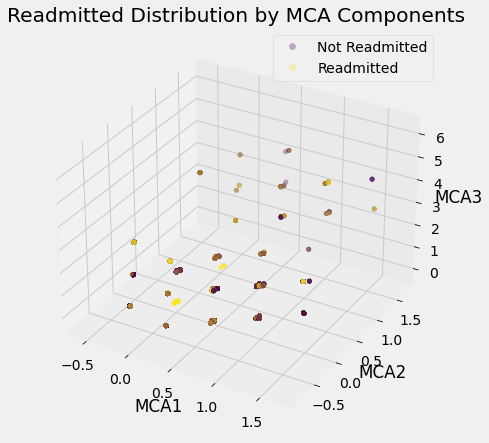

In [64]:
#Plot the scores on the first three MCA components and color by the readmitted variable to see how well the MCA components
#separate the classes
ax = plt.figure(figsize=(10, 7)).gca(projection='3d')
scatter = ax.scatter(xs=mca['MCA1'], ys=mca['MCA2'], zs=mca['MCA3'], c=mca['readmitted'],alpha=0.3)
ax.set_xlabel('MCA1')
ax.set_ylabel('MCA2')
ax.set_zlabel('MCA3')
ax.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.title('Readmitted Distribution by MCA Components')

### Trying MCA - Diag Columns

Text(0.5, 1.0, 'Readmitted Distribution by MCA Components')

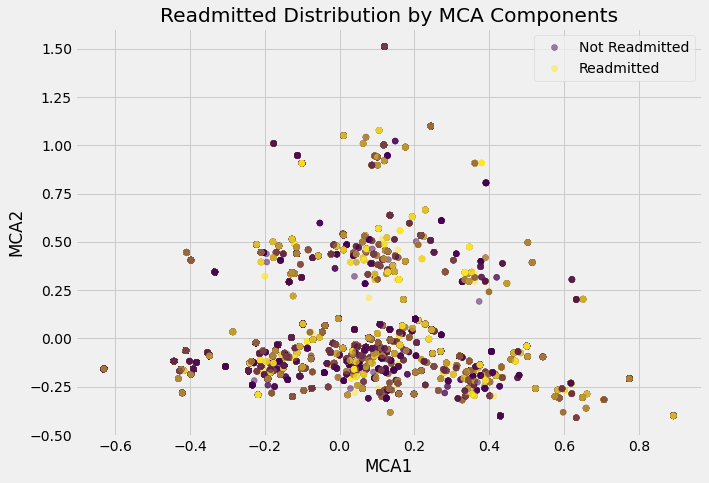

In [65]:
#Get just the columns corresponding to whether a particular drug was prescribed or not
df_diag = X_train.loc[:,'diag_1_Diabetes':'diag_3_Respiratory']
#For every drug column, change 0 values to "No" and 1 values to "Yes"
for col in df_diag.columns:
    df_diag[col] = df_diag[col].replace({0:'No',1:'Yes'})
#Do MCA on the drugs columns
mca = prince.MCA(n_components = 3, random_state = 1)
mca_fitted = mca.fit(df_diag)
mca = mca_fitted.transform(df_diag)
#Rename the columns
mca.columns = ['MCA1','MCA2','MCA3']
#Add the target variable to the data frame
mca['readmitted'] = y_train
#Plot the first two MCA components colored by the readmitted variable
plt.figure(figsize=(10, 7))
scatter = plt.scatter(mca['MCA1'],mca['MCA2'],c=mca['readmitted'],alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.xlabel('MCA1')
plt.ylabel('MCA2')
plt.title('Readmitted Distribution by MCA Components')

## See how well the variable reduction is working

In [66]:
#Fit a random forest with the quantitative predictors
rf = RandomForestClassifier(random_state=1,oob_score=True)
rf_fitted = rf.fit(X_train[['time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications', 'number_outpatient', 'number_emergency','number_inpatient', 'number_diagnoses']],y_train)
#Get the out of bag error
rf_fitted.oob_score_

0.785684651401703

In [67]:
#Fit a random forest with the LDA component to see if it's better than the quantitative predictors
rf = RandomForestClassifier(random_state=1,oob_score=True)
rf_fitted = rf.fit(X_train[['LDA1']],y_train)
#Get the out of bag error
rf_fitted.oob_score_

0.6852243317462513

In [68]:
#Fit a random forest with the drugs columns
rf = RandomForestClassifier(random_state=1,oob_score=True)
rf_fitted = rf.fit(X_train[['insulin', 'change','Biguanide', 'Meglitinide', 'Sulfonylurea', 'Thiazolidinedione','Alpha-glucosidase inhibitor']],y_train)
#Get the out of bag error
rf_fitted.oob_score_

0.6223995890708656

In [69]:
#Fit a random forest with the drugs columns
rf = RandomForestClassifier(random_state=1,oob_score=True)
rf_fitted = rf.fit(X_train[['MCA1','MCA2','MCA3']],y_train)
#Get the out of bag error
rf_fitted.oob_score_

0.622379832862477

## Briefly Do Dimensional Reduction for Multiclass problem

### Multiclass LDA

In [70]:
#Split the data into training and testing sets
X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(df_multiclass.drop(['readmitted'],axis=1),df_multiclass['readmitted'],test_size=0.25,random_state=1)
#Getting the quantitative variables
X_train_quant_multiclass = X_train_multiclass.loc[:, df_quant.columns]
#Standardizing the quantitative variables
X_train_quant_scaled_multiclass = pd.DataFrame(StandardScaler().fit_transform(X_train_quant_multiclass),index=X_train_quant_multiclass.index)
#Rename the columns to be the same as the original data
X_train_quant_scaled_multiclass.columns = X_train_quant_multiclass.columns
#scale the test data according to the training data
X_test_quant_scaled_multiclass = pd.DataFrame(StandardScaler().fit(X_train_quant_multiclass).transform(X_test_multiclass.loc[:, df_quant.columns]),index=X_test_multiclass.index)
#Rename the columns to be the same as the original data
X_test_quant_scaled_multiclass.columns = X_train_quant_multiclass.columns

<AxesSubplot:xlabel='readmitted', ylabel='0'>

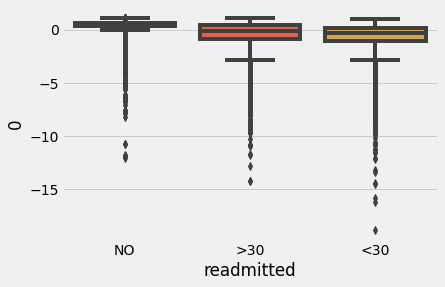

In [71]:
#Set up LDA model
lda_multiclass = LinearDiscriminantAnalysis(n_components=2)
#Fit the model to the quantitative variables with the readmitted variable being the class to try to separate on
lda_multiclass.fit(X_train_quant_scaled_multiclass,y_train_multiclass)
#Apply the model to the quantitative variables
lda_scores_multiclass = lda_multiclass.transform(X_train_quant_scaled_multiclass)
#Put the scores into a data frame
df_lda_multiclass = pd.DataFrame(lda_scores_multiclass,index=X_train_quant_scaled_multiclass.index)
df_lda_multiclass['readmitted'] = y_train_multiclass
#Make a boxplot of the transformed data faceted by the readmitted variable
sns.boxplot(x=df_lda_multiclass['readmitted'],y=df_lda_multiclass[0])

Text(0, 0.5, 'LDA2')

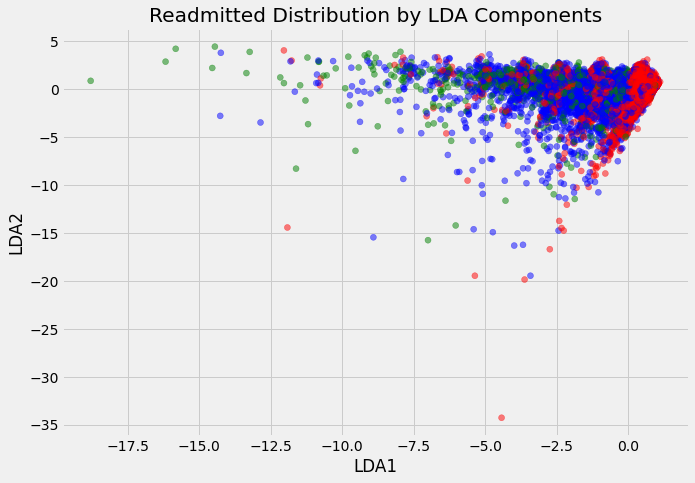

In [77]:
#Make a scatterplot of the first two LDA components colored by the readmitted variable
plt.figure(figsize=(10, 7))
colors = {'NO':'red', '<30':'green', '>30':'blue'}
scatter = plt.scatter(df_lda_multiclass[0],df_lda_multiclass[1],c=df_lda_multiclass['readmitted'].map(colors),alpha=0.5)
plt.title('Readmitted Distribution by LDA Components')
plt.xlabel('LDA1')
plt.ylabel('LDA2')